In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import models, layers, regularizers
# import matplotlib.pyplot as plt

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152, EfficientNetB7
# from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.regularizers import l2

In [ ]:
# # from keras.applications import ResNet50
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.layers import Dropout

In [11]:
IMAGE_HEIGHT = 400
IMAGE_WIDTH = 300
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/myproject1/Project 1 Data/Train_Data",
    shuffle = True,
    image_size =(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 2516 files belonging to 5 classes.


In [13]:
class_names = dataset.class_names
class_names

['A', 'B', 'C', 'D', 'S']

In [14]:
labels = np.concatenate([labels for _, labels in dataset])
n_classes = len(class_names)
n_classes

5

In [15]:
for image_batch, labels_batch in dataset.take(1): # reading images in 1 batch
    print(image_batch.shape)
    print(labels_batch.numpy())
   # print(image_batch[0].numpy())
    print(image_batch[0].shape)

(32, 400, 300, 3)
[3 0 3 3 2 2 1 3 2 0 2 4 2 1 3 4 2 3 0 3 1 1 1 2 3 3 4 2 3 0 2 3]
(400, 300, 3)


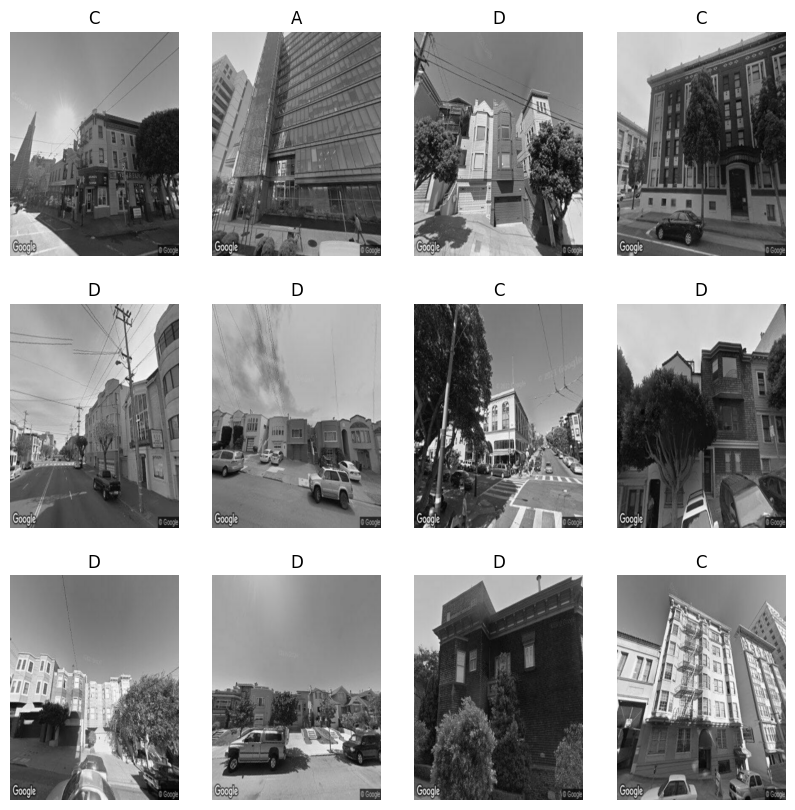

In [16]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range (12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [17]:
def get_dataset_partitions_tf(ds, train_split = 0.9, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
print(len(train_ds), len(val_ds), len(test_ds))

71 8 1


In [20]:
for images, labels in train_ds.take(1):
    print(images.shape)  # This should print something like (batch_size, 400, 300, 3)
    print(labels.shape) 

(32, 400, 300, 3)
(32,)


In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

In [14]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.3),
#     layers.RandomZoom(0.2),
#     layers.RandomBrightness(factor=0.2),
#     layers.RandomContrast(factor=0.2),
#     layers.RandomTranslation(width_factor=0.2, height_factor=0.2),
#     layers.RandomCrop(width=IMAGE_WIDTH,height=IMAGE_HEIGHT),
#     layers.GaussianNoise(stddev=0.05),

# ])

In [ ]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(resize_and_rescale(x)), y))
# val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# def augment_minority_classes(image, label):
#     minority_class_condition = tf.reduce_any(tf.equal(label, [0, 1, 4]))
    
#     augmented_image = tf.cond(
#         minority_class_condition,  # condition to check if the class is in the minority classes
#         lambda: data_augmentation(image),  # apply augmentation if true
#         lambda: image  # return original image if false
#     )
#     return augmented_image, label
    
    
# #     if label in [0, 1, 4]:  # Assuming A=0, B=1, S=4
# #         return data_augmentation(image), label
# #     return image, label

# # train_ds = train_ds.map(augment_minority_classes)

In [24]:
labels = np.concatenate([y.numpy() for _, y in dataset])

In [25]:
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: class_weights[i] for i in range(n_classes)}

In [ ]:
# def oversample_dataset(ds):
#     X = np.concatenate([images for images, _ in ds], axis=0)
#     y = np.concatenate([labels for _, labels in ds], axis=0)
#     ros = RandomOverSampler(sampling_strategy='not majority')
#     X_resampled, y_resampled = ros.fit_resample(X.reshape((len(X), -1)), y)
#     X_resampled = X_resampled.reshape((-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
#     return tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))

# train_ds = oversample_dataset(train_ds)

In [ ]:
# BATCH_SIZE = 32  # or your preferred batch size

# train_ds = train_ds.batch(BATCH_SIZE)
# # val_ds = val_ds.batch(BATCH_SIZE)
# # test_ds = test_ds.batch(BATCH_SIZE)


In [ ]:
# for image_batch, labels_batch in val_ds.take(1): # reading images in 1 batch
#     print(image_batch.shape)
#     print(labels_batch.numpy())
#    # print(image_batch[0].numpy())
#     print(image_batch[0].shape)

In [26]:
for images, labels in train_ds.take(1):
    print(images.shape)  # This should print something like (batch_size, 400, 300, 3)
    print(labels.shape)  # This should print (batch_size,)
    
# for images, labels in val_ds.take(1):
#     print(images.shape)  # This should print something like (batch_size, 400, 300, 3)
#     print(labels.shape)  # This should print (batch_size,)

(32, 400, 300, 3)
(32,)


In [ ]:
# input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
# n_classes = 5


# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation = 'relu'),
#     layers.Dense(n_classes, activation = 'softmax'),
# ])

# model.build(input_shape = input_shape)

In [ ]:
# base_model = ResNet152(weights='/kaggle/input/resnet152/resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))

# for layer in base_model.layers:
#     layer.trainable = False

# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Pool the features
# x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Fully connected layer
# x = Dropout(0.2)(x)
# x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.2)(x) 
# predictions = Dense(5, activation='softmax')(x)  # 5 output classes


In [ ]:
# def unet_model():
#     inputs = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))

#     # Downsampling path
#     c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
#     c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     # Bottleneck
#     c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
#     c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

#     # Upsampling path
#     u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
#     u4 = layers.concatenate([u4, c2])
#     c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
#     c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

#     u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
#     u5 = layers.concatenate( [u5, c1])
#     c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
#     c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

#     outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)  # Sigmoid for binary segmentation

#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return model

In [ ]:
# X_train, y_train = [], []
# for images, labels in train_ds:
#     X_train.append(images)
#     y_train.append(labels)

# X_train = tf.concat(X_train, axis=0)
# y_train = tf.concat(y_train, axis=0)

# X_val, y_val = [], []
# for images, labels in val_ds:
#     X_val.append(images)
#     y_val.append(labels)

# X_val = tf.concat(X_val, axis=0)
# y_val = tf.concat(y_val, axis=0)

In [ ]:
# resnet = ResNet50(weights='/kaggle/input/resnetweights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
# efficient_net = EfficientNetB0(weights='/kaggle/input/efficientweigths/efficientnetb0_notop.h5', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
# # inception = InceptionV3(weights='/kaggle/input/inceptionweights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))

In [ ]:
# for model in [resnet, efficient_net]:
#     model.trainable = False

In [ ]:
# n_classes =5

# # Input layer
# input_layer = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))

# # Get outputs from each model
# resnet_output = resnet(input_layer)
# efficient_output = efficient_net(input_layer)
# # inception_output = inception(input_layer)

# # Global Average Pooling for each model's output
# resnet_output = GlobalAveragePooling2D()(resnet_output)
# efficient_output = GlobalAveragePooling2D()(efficient_output)
# # inception_output = GlobalAveragePooling2D()(inception_output)

# # Concatenate outputs
# combined_output = Concatenate()([resnet_output, efficient_output])

# # Add fully connected layers
# x = Dropout(0.2)(combined_output)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
# output_layer = Dense(n_classes, activation='softmax')(x)

# # Create the ensemble model
# ensemble_model = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
# n_classes = 5
# base_model = ResNet152(weights='/kaggle/input/resnet152/resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
# base_model.trainable = False  # Freeze base model layers

# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.2),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(n_classes, activation='softmax')
# ])

In [27]:
n_classes = 5
base_model = EfficientNetB7(weights='/kaggle/input/efficientnetb7/efficientnetb7_notop.h5', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
base_model.trainable = False  # Freeze base model layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])


# # model = models.Sequential([
# #     base_model,
# #     layers.GlobalAveragePooling2D(),
# #     layers.Dropout(0.1),
# #     layers.Dense(512, activation='relu'),
# #     layers.Dropout(0.1),
# #     layers.Dense(n_classes, activation='softmax')
# # ])

In [20]:
# n_classes = 5
# base_model = EfficientNetV2M(weights='/kaggle/input/efficientnetv2m/efficientnetv2-m_notop.h5', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# base_model.trainable = False  # Freeze base model layers

# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),  # Increase dropout for regularization
#     layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Increase neurons to 512
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Add another dense layer
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(n_classes, activation='softmax')  # Final classification layer
# ])


# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.2),
#     layers.Dense(n_classes, activation='softmax')
# ])

In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# # model = Model(inputs=unet_model().input, outputs=predictions)
# model = unet_model()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_kaggle.keras',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min'  # We want the minimum validation loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by half
    patience=3,         # Wait 3 epochs before reducing
    min_lr=1e-6         # Minimum learning rate
)

In [ ]:
# train_images = tf.image.resize(train_images, [IMAGE_WIDTH, IMAGE_HEIGHT]) / 255.0
# train_masks = tf.image.resize(train_masks, [IMAGE_WIDTH, IMAGE_HEIGHT]) / 255.0

In [ ]:
# history = model.fit(X_train, y_train, 
#           validation_data=(X_val, y_val), 
#           epochs=EPOCHS, 
#           verbose = 1,
#           callbacks=[early_stopping, model_checkpoint, reduce_lr]
# )

In [24]:

history = model.fit(
     train_ds,
     epochs = EPOCHS,
     batch_size = BATCH_SIZE,
     verbose = 1,
     validation_data = val_ds,
     class_weight=class_weight_dict,
     callbacks=[early_stopping, model_checkpoint, reduce_lr]
 )

Epoch 1/50


I0000 00:00:1728222935.659716     655 service.cc:145] XLA service 0x7b23bc002f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728222935.659759     655 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728223042.785999     655 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 176s 507ms/step - accuracy: 0.3530 - loss: 3.0918 - val_accuracy: 0.5898 - val_loss: 2.3136 - learning_rate: 0.0010
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.5133 - loss: 2.3806 - val_accuracy: 0.6875 - val_loss: 2.1142 - learning_rate: 0.0010
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.5973 - loss: 2.1300 - val_accuracy: 0.6211 - val_loss: 2.0356 - learning_rate: 0.0010
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.6499 - loss: 1.9666 - val_accuracy: 0.7383 - val_loss: 1.8665 - learning_rate: 0.0010
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.6662 - loss: 1.8366 - val_accuracy: 0.7695 - val_loss: 1.7080 - learning_rate: 0.0010
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.7010 - loss: 1.8082 - val_accuracy: 0.8242 - val_loss: 1.6424 - learning_rate: 0.0010
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - accuracy: 0.7481 - loss: 1.6358 - val

In [26]:
model = tf.keras.models.load_model('/kaggle/working/best_model_kaggle.keras')

In [27]:
scores = model.evaluate(test_ds)
scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.9688 - loss: 0.5572


[0.5572386384010315, 0.96875]

In [ ]:
# # # base_model.trainable = True  # Unfreeze the whole base model

# # Optionally, freeze all layers except the last few
# fine_tune_at = len(base_model.layers) - 30  # Unfreeze the last 30 layers
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Compile again with a lower learning rate
# optimizer = Adam(learning_rate=1e-5)  # Lower learning rate for fine-tuning
# model.compile(optimizer=optimizer, 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#               metrics=['accuracy'])

# # Fine-tune the model
# history_fine = model.fit(
#     train_ds,
#     epochs=10,  # Fine-tune for 5-10 more epochs
#     batch_size=BATCH_SIZE,
#     validation_data=val_ds,
#     callbacks=[early_stopping, model_checkpoint, reduce_lr]
# )

In [ ]:
scores = model.evaluate(test_ds)
scores

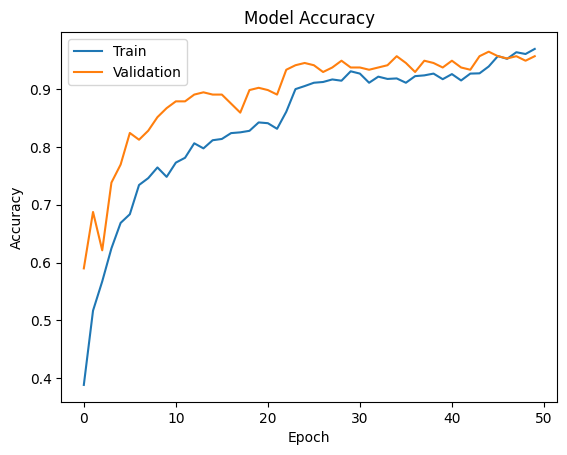

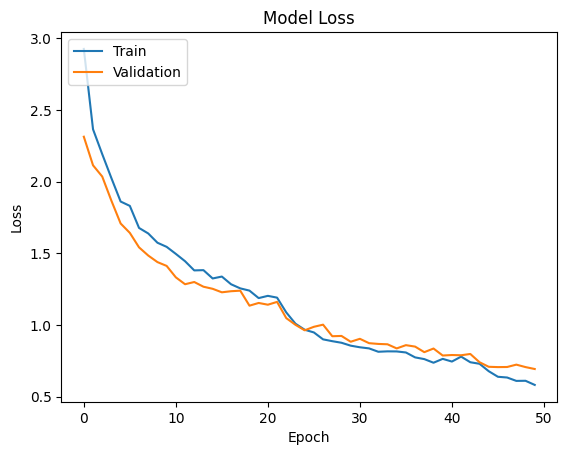

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [30]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])))
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


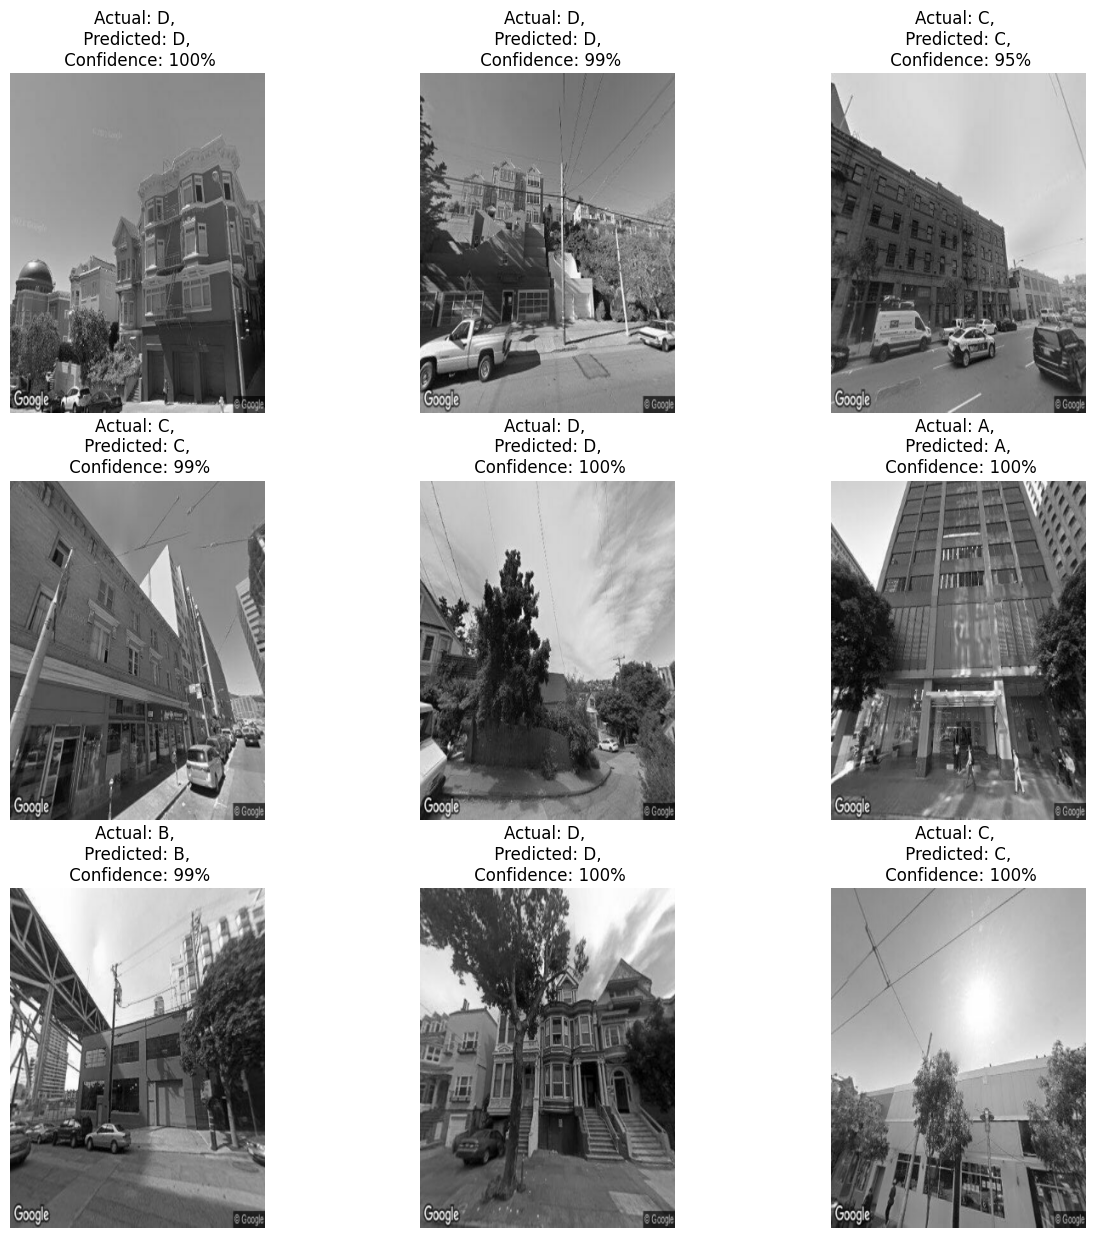

In [31]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

    plt.axis("off")

In [32]:
# Save the model to Google Drive
model.save('/kaggle/working/my_building_9570effBV2M.keras')

In [33]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

# Load your trained model
# model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/my_building_9018.keras')  # Update with your model path

# Define the class names (update this list based on your model)
# class_names = ['A', 'B', 'C', 'D', 'S']  # Update this list

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])))
    return predicted_class, confidence

# Path to the Test_data folder
test_data_folder = '/kaggle/input/myproject1/Project 1 Data/Test_Data'

# Initialize lists to store IDs and predictions
ids = []
predictions = []
labels = ['A','B','C','D','S']

# Loop through all images in the Test_data folder
for i in range(1, 479):  # IDs from 1 to 478
    image_path = os.path.join(test_data_folder, f'{i}.jpg')

    if os.path.exists(image_path):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))  # Specify the target size
        predicted_class, confidence = predict(model, img)

        ids.append(i)
        predictions.append(labels.index(predicted_class)+1)  # You can include confidence if needed
    else:
        print(f"Image {image_path} not found.")

# Create a DataFrame from the lists
results_df = pd.DataFrame({
    'ID': ids,
    'Prediction': predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv(f'/kaggle/working/submission_9570effV2M.csv', index=False)
print("Predictions saved to predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━